In [1]:
# imports
import torch

from model.squeezedet import SqueezeDet, SqueezeDetWithLoss
from utils.config import Config
from utils.model import load_model
from PIL import Image
import numpy as np
import argparse
import os
from utils.misc import init_env

from engine.detector import Detector
from model.squeezedet import SqueezeDetWithLoss
from utils.model import load_model
from utils.misc import load_dataset


In [2]:
# args = {'_': '_'}

# args = ['train',
# '--load_model' , '../models/imagenet/squeezenet1_1-f364aa15.pth', 
# '--batch_size' , '4',
# '--num_workers' , '0',
# "--gpus" , '-1',
# "--num_epochs" , "5",
# "--exp_id" , "test_train_20"
# ]

# cfg = Config().parse(args)

# init_env(cfg) 
# Config().print(cfg)


In [3]:
# train_dataset = Dataset('train', cfg)
# val_dataset = Dataset('val', cfg)
# cfg = Config().update_dataset_info(cfg, train_dataset)
# Config().print(cfg)

# from train import train
# train(cfg)

### Flow
dataset-> dataloader -> aarch -> loss func -> training loop

### The Kitti Dataset

In [4]:
import os
import subprocess

import numpy as np
import skimage.io

from datasets.base import BaseDataset
from utils.boxes import *


In [5]:
import cv2

def get_sample_ids(data_dir, phase):
    sample_set_name = 'train_20.txt' if phase == 'train' \
        else 'val_20.txt' if phase == 'val' \
        else 'trainval.txt' if phase == 'trainval' \
        else None

    sample_ids_path = os.path.join(data_dir, 'image_sets', sample_set_name)
    with open(sample_ids_path, 'r') as fp:
        sample_ids = fp.readlines()
    sample_ids = tuple(x.strip() for x in sample_ids)

    return sample_ids, sample_ids_path




def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

In [6]:
data_dir= '../data/'

input_size = (384, 1248)  # (height, width), both dividable by 16
class_names = ('Car', 'Pedestrian', 'Cyclist')
rgb_mean = np.array([93.877, 98.801, 95.923], dtype=np.float32).reshape(1, 1, 3)
rgb_std = np.array([78.782, 80.130, 81.200], dtype=np.float32).reshape(1, 1, 3)

num_classes = len(class_names)
class_ids_dict = {cls_name: cls_id for cls_id, cls_name in enumerate(class_names)}

print (class_ids_dict)

data_dir = os.path.join(data_dir, 'kitti')
sample_ids, sample_set_path = get_sample_ids(data_dir=data_dir, phase='train')
print (sample_ids)
print (sample_set_path)

grid_size = tuple(x // 16 for x in input_size)  # anchors grid

# ancjors seed is basically length and width of anchors generated from looking at dataset
anchors_seed = np.array([[34, 30], [75, 45], [38, 90],
                                [127, 68], [80, 174], [196, 97],
                                [194, 178], [283, 156], [381, 185]], dtype=np.float32) 
anchors = generate_anchors(grid_size, input_size, anchors_seed)
anchors_per_grid = anchors_seed.shape[0]
num_anchors = anchors.shape[0]

# results_dir = os.path.join(cfg.save_dir, 'results')

{'Car': 0, 'Pedestrian': 1, 'Cyclist': 2}
('000000', '000008', '000012', '000014', '000015', '000017', '000019', '000023', '000025', '000026', '000029', '000030', '000031', '000032', '000033', '000037', '000039', '000041', '000043', '000044')
../data/kitti/image_sets/train_20.txt


../data/kitti/training/image_2/000000.png
(384, 1248, 3)


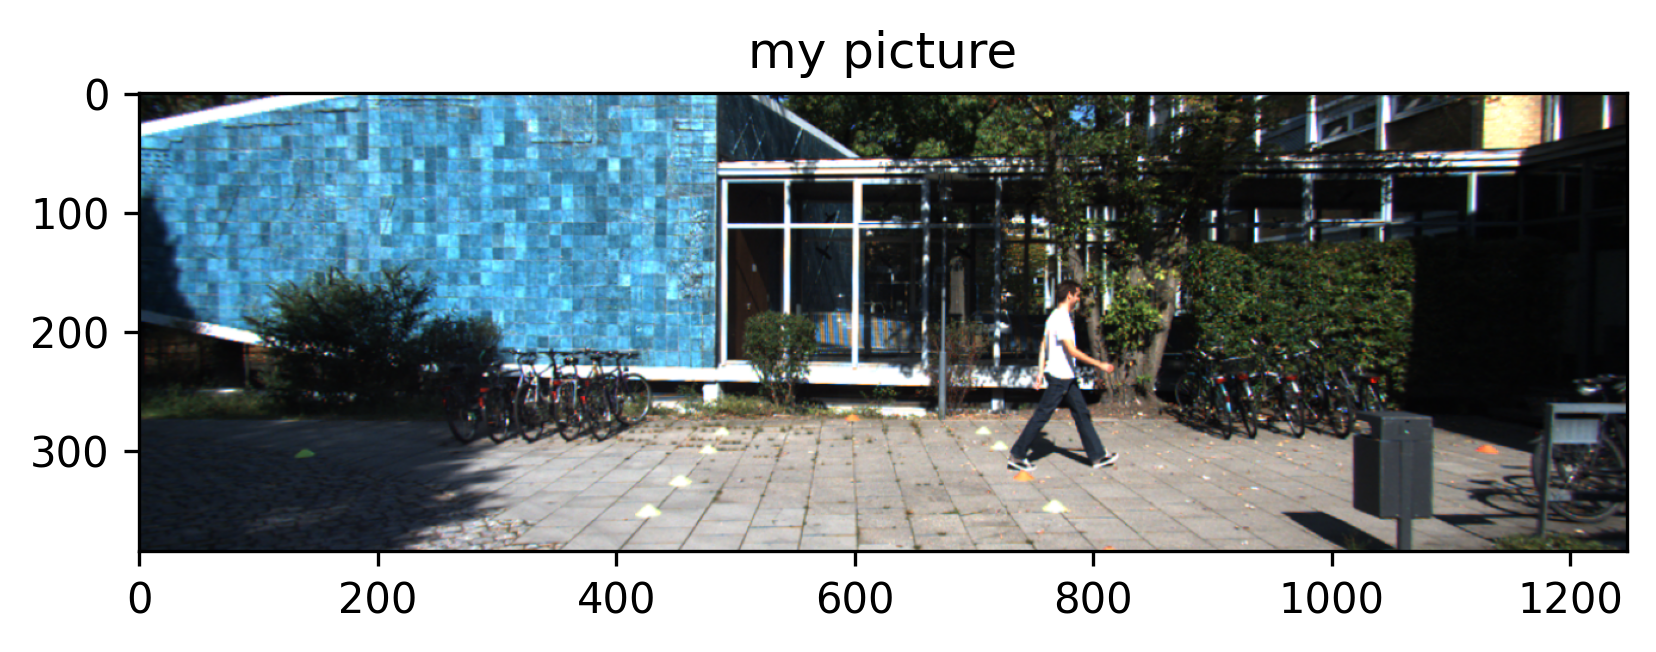

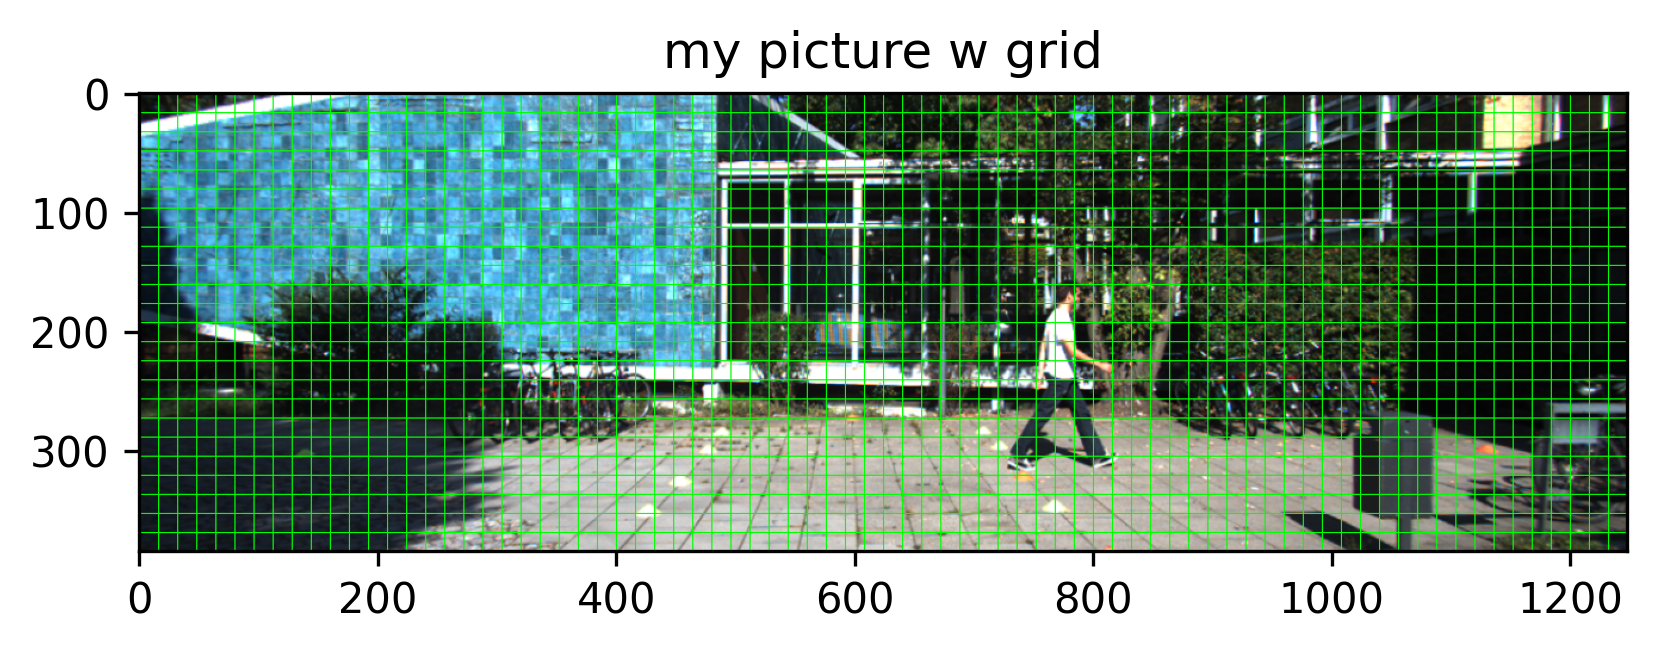

(18, 4)
[[  8.   8.  34.  30.]
 [  8.   8.  75.  45.]
 [  8.   8.  38.  90.]
 [  8.   8. 127.  68.]
 [  8.   8.  80. 174.]
 [  8.   8. 196.  97.]
 [  8.   8. 194. 178.]
 [  8.   8. 283. 156.]
 [  8.   8. 381. 185.]
 [664. 200.  34.  30.]
 [664. 200.  75.  45.]
 [664. 200.  38.  90.]
 [664. 200. 127.  68.]
 [664. 200.  80. 174.]
 [664. 200. 196.  97.]
 [664. 200. 194. 178.]
 [664. 200. 283. 156.]
 [664. 200. 381. 185.]]


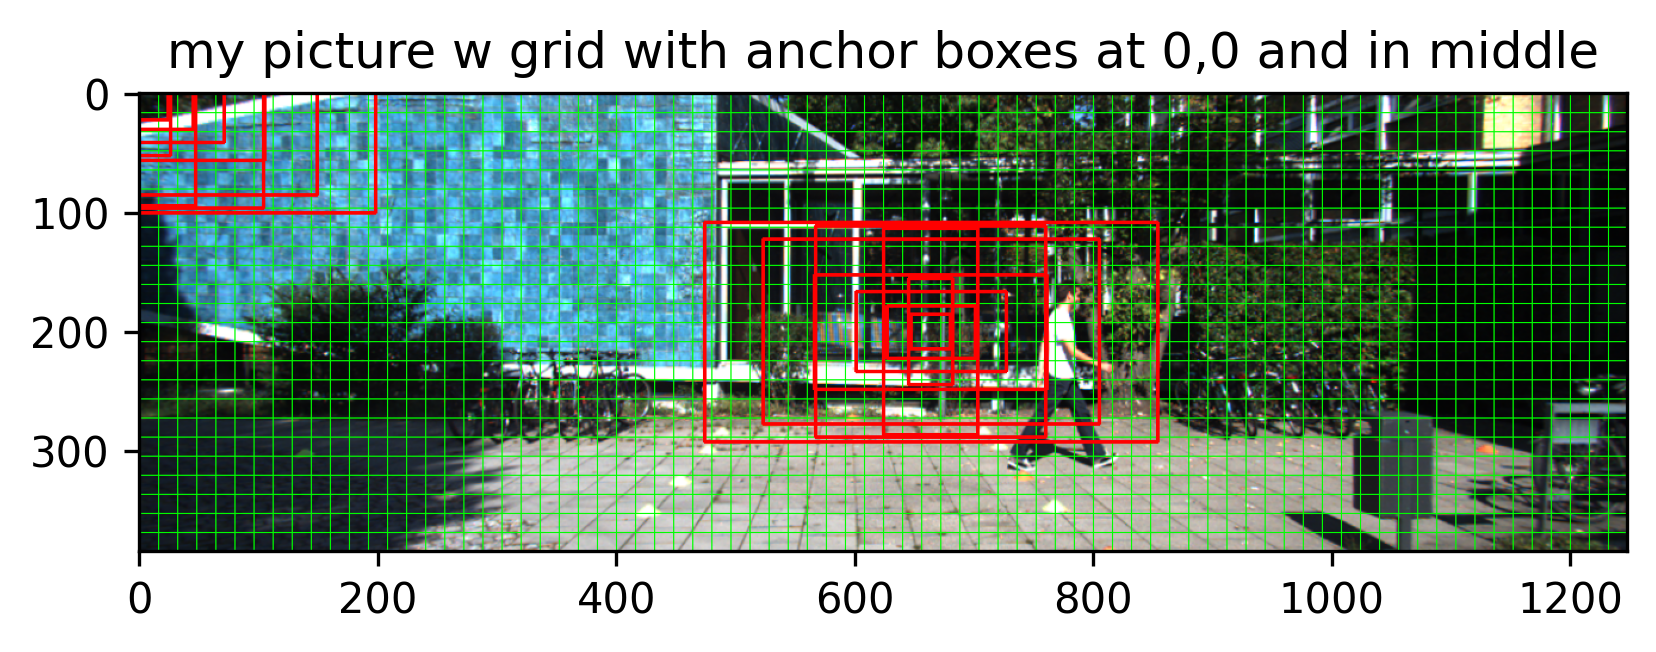

In [7]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 300
import cv2
import copy

imag_path = os.path.join(data_dir,'training','image_2', sample_ids[0]) + '.png'
print (imag_path)
img = cv2.imread(imag_path)
img = cv2.resize(img, (input_size[1], input_size[0]), cv2.INTER_AREA)
print (img.shape)
img_ = copy.deepcopy(img)

img_grid = draw_grid(img,(24,78))
# cv2.imwrite('../data/samples/image_w_grid.png', img_grid)

img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
img_grid = cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB)
img_grid_ = copy.deepcopy(img_grid)

plt.imshow(img_)
plt.title('my picture')
plt.show()

plt.imshow(img_grid)
plt.title('my picture w grid')
plt.show()

#plotting anchors on (0,0) grid cell

anchors_0_0 = anchors[0:9,:]
anchors_middle = anchors[8793:8802,:] #anchors of a grid cell somehwhere in the middle to plot properly
anchors_to_plot  = np.concatenate([anchors_0_0, anchors_middle],0)
print (anchors_to_plot.shape)
print (anchors_to_plot)

anchors_to_plot_xyxy = xywh_to_xyxy(anchors_to_plot).astype(np.int32)
# anchors_0_0_xyxy = anchors_0_0_xyxy.astype(np.int32)

for i in range(anchors_to_plot_xyxy.shape[0]):

    start_point = (anchors_to_plot_xyxy[i,0], anchors_to_plot_xyxy[i,1])  
    end_point = (anchors_to_plot_xyxy[i,2], anchors_to_plot_xyxy[i,3])
    # Blue color in BGR
    color = (255, 0, 0)  
    # Line thickness of 2 px
    thickness = 2  
    img_grid_ = cv2.rectangle(img_grid_, start_point, end_point, color, thickness)


plt.imshow(img_grid_)
plt.title('my picture w grid with anchor boxes at 0,0 and in middle')
plt.show()

In [8]:
class KittiDataset(torch.utils.data.Dataset):
    def __init__(self, phase = 'train'):
        self.train_image_set_path = '/home/gjraza/gj/squeezedet_impl/SqueezeDet-PyTorch/data/kitti/image_sets/train_20.txt'
        self.valid_image_set_path = '/home/gjraza/gj/squeezedet_impl/SqueezeDet-PyTorch/data/kitti/image_sets/val_20.txt'  

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

    def get_sample_ids(data_dir, phase):
    sample_set_name = 'train_20.txt' if phase == 'train' \
        else 'val_20.txt' if phase == 'val' \
        else 'trainval.txt' if phase == 'trainval' \
        else None

    sample_ids_path = os.path.join(data_dir, 'image_sets', sample_set_name)
    with open(sample_ids_path, 'r') as fp:
        sample_ids = fp.readlines()
    sample_ids = tuple(x.strip() for x in sample_ids)

    return sample_ids, sample_ids_path